In [ ]:
import json
import glob, pickle

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima, FakeBelem

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder
from gnn import ExpValCircuitGraphModel
plt.style.use({'figure.facecolor':'white'})

In [ ]:
backend1 = FakeLima()
backend2 = FakeBelem()
properties1 = get_backend_properties_v1(backend1)
properties2 = get_backend_properties_v1(backend2)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend1_noisy = AerSimulator.from_backend(backend1) # Noisy
backend2_noisy = AerSimulator.from_backend(backend2) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy1 = {'shots': 10000, 'backend': backend1_noisy, 'name': 'noisy'}
run_config_noisy2 = {'shots': 10000, 'backend': backend2_noisy, 'name': 'noisy'}

# Train on Backend 1

In [1]:
train_paths = [
    f'./data/circ_parsed_pyg_data/train/fakelima_depth{i}.json' for i in range(1, 10)
]

val_paths = [
    f'./data/circ_parsed_pyg_data/val/fakelima/fakelima_depth{i}.json' for i in range(1, 10)
]

In [2]:
BATCH_SIZE = 32

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

NameError: name 'DataLoader' is not defined

In [18]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=5
)
criterion = torch.nn.MSELoss()

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

In [19]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad), len(train_loader) * BATCH_SIZE, len(val_loader) * BATCH_SIZE)

13676 9024 3616


In [20]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 100

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 00039: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00055: reducing learning rate of group 0 to 1.0000e-05.


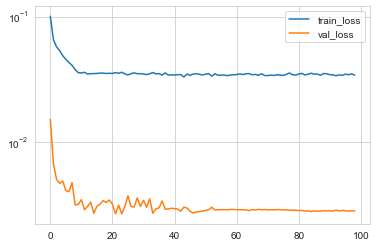

In [21]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

In [22]:
model_path = './model/finetuning/train_fakelima.pth'

In [23]:
# torch.save(model.state_dict(), model_path)

In [24]:
# to_save = {'train_losses': train_losses, 'val_losses': val_losses}
# with open('.'+model_path.split('.')[1]+'.pk', 'wb') as handle:
#     pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test on Backend 2

In [92]:
model_path = './model/finetuning/train_fakelima.pth'

In [93]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=5
)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [94]:
dfs = {}
model.eval()
for d in tqdm_notebook(range(1, 10)):
    test_paths = [
        f'./data/circ_parsed_pyg_data/val/fakelima/fakelima_depth{d}.json'
    ]

    test_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            test_paths,
        ),
        batch_size=10000000,
        shuffle=False
    )

    distances = []
    for i, data in enumerate(test_loader):
        out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)

        for ideal, noisy, ngm_mitigated in zip(
            data.y.tolist(),
            data.noisy_0.tolist(),
            out.tolist()
        ):
            ideal = np.mean(ideal)
            noisy = np.mean(noisy)
            ngm_mitigated = np.mean(ngm_mitigated)
            distances.append({
                "ideal": ideal,
                "noisy": noisy,
                "ngm_mitigated": ngm_mitigated,
                "dist_noisy": np.abs(ideal - noisy),
                "dist_ngm": np.abs(ideal - ngm_mitigated),
            })

    df = pd.DataFrame(distances)
    dfs[d] = df

# sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
# plt.title("Dist to ideal exp value")
# plt.show()
#
# sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
# plt.title("Exp values distribution")
# plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

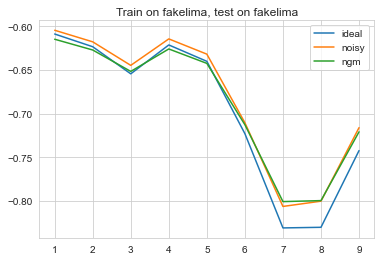

In [95]:
plt.style.use({'figure.facecolor':'white'})

y_ideal = []
y_noisy = []
y_ngm = []
for depth in dfs.keys():
    y_ideal.append(dfs[depth]['ideal'].mean())
    y_noisy.append(dfs[depth]['noisy'].mean())
    y_ngm.append(dfs[depth]['ngm_mitigated'].mean())

plt.plot(np.arange(1, 10), y_ideal, label='ideal')
plt.plot(np.arange(1, 10), y_noisy, label='noisy')
plt.plot(np.arange(1, 10), y_ngm, label='ngm')
plt.title('Train on fakelima, test on fakelima')
plt.legend()

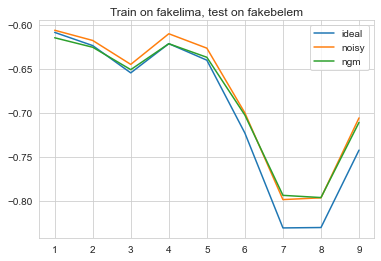

In [82]:
plt.style.use({'figure.facecolor':'white'})

y_ideal = []
y_noisy = []
y_ngm = []
for depth in dfs.keys():
    y_ideal.append(dfs[depth]['ideal'].mean())
    y_noisy.append(dfs[depth]['noisy'].mean())
    y_ngm.append(dfs[depth]['ngm_mitigated'].mean())

plt.plot(np.arange(1, 10), y_ideal, label='ideal')
plt.plot(np.arange(1, 10), y_noisy, label='noisy')
plt.plot(np.arange(1, 10), y_ngm, label='ngm')
plt.title('Train on fakelima, test on fakebelem')
plt.legend()

# Finetune on Backend 2

In [63]:
model_path = './model/finetuning/train_fakelima.pth'

'./model/finetuning/train_fakelima.pth'

In [64]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=5
)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [65]:
finetune_paths = [
    f'./data/circ_parsed_pyg_data/finetune/fakebelem_depth{i}.json' for i in range(1, 10)
]

test_paths = [
    f'./data/circ_parsed_pyg_data/val/fakebelem_depth{i}.json' for i in range(1, 10)
]

finetune_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        finetune_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        test_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [66]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad), len(finetune_loader) * BATCH_SIZE, len(test_loader) * BATCH_SIZE)

13676 2720 3616


In [67]:
min_valid_loss = np.inf

finetune_losses = []
test_losses = []

N_EPOCHS = 100

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    finetune_loss = 0.0
    model.train()
    for i, data in enumerate(finetune_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))

        finetune_loss += loss.item()

        loss.backward()
        optimizer.step()

    test_loss = 0.0
    model.eval()
    for i, data in enumerate(test_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))

        test_loss += loss.item()

    scheduler.step(test_loss)

    if epoch >= 1:
        finetune_losses.append(finetune_loss / len(finetune_loader))
        test_losses.append(test_loss / len(test_loader))

        progress.set_description(f"{round(finetune_losses[-1], 5)}, {round(test_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/100 [00:00<?, ?it/s]

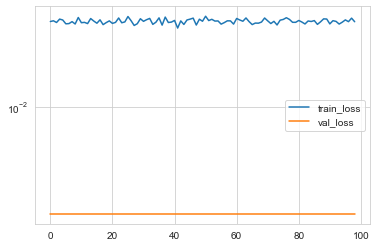

In [75]:
plt.plot(finetune_losses, label="train_loss")
plt.plot(test_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

In [73]:
model_path = './model/finetuning/finetune_fakebelem.pth'

In [74]:
# torch.save(model.state_dict(), model_path)

In [76]:
# to_save = {'train_losses': train_losses, 'val_losses': val_losses}
# with open('.'+model_path.split('.')[1]+'.pk', 'wb') as handle:
#     pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test on Backend 2

In [83]:
model_path = './model/finetuning/finetune_fakebelem.pth'

In [84]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=5
)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [85]:
dfs = {}
model.eval()
for d in tqdm_notebook(range(1, 10)):
    test_paths = [
        f'./data/circ_parsed_pyg_data/val/fakebelem_depth{d}.json'
    ]

    test_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            test_paths,
        ),
        batch_size=10000000,
        shuffle=False
    )

    distances = []
    for i, data in enumerate(test_loader):
        out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)

        for ideal, noisy, ngm_mitigated in zip(
            data.y.tolist(),
            data.noisy_0.tolist(),
            out.tolist()
        ):
            ideal = np.mean(ideal)
            noisy = np.mean(noisy)
            ngm_mitigated = np.mean(ngm_mitigated)
            distances.append({
                "ideal": ideal,
                "noisy": noisy,
                "ngm_mitigated": ngm_mitigated,
                "dist_noisy": np.abs(ideal - noisy),
                "dist_ngm": np.abs(ideal - ngm_mitigated),
            })

    df = pd.DataFrame(distances)
    dfs[d] = df

  0%|          | 0/9 [00:00<?, ?it/s]

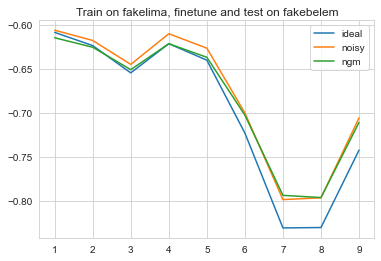

In [87]:
plt.style.use({'figure.facecolor':'white'})

y_ideal = []
y_noisy = []
y_ngm = []
for depth in dfs.keys():
    y_ideal.append(dfs[depth]['ideal'].mean())
    y_noisy.append(dfs[depth]['noisy'].mean())
    y_ngm.append(dfs[depth]['ngm_mitigated'].mean())

plt.plot(np.arange(1, 10), y_ideal, label='ideal')
plt.plot(np.arange(1, 10), y_noisy, label='noisy')
plt.plot(np.arange(1, 10), y_ngm, label='ngm')
plt.title('Train on fakelima, finetune and test on fakebelem')
plt.legend()

# Train on Backend 2 from scratch

# Test on Backend 2